In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
tickers = ['xle', 'xlu', 'xlb', 'xlk', 'xli', 'xlv', 'xlf', 'xlp', 'xly']
end_date = '2023-07-16'

In [3]:
price_dataframe = yf.download(tickers, end=end_date)['Close']

preprocessed_dataframe = price_dataframe.fillna(method='ffill')
preprocessed_dataframe = preprocessed_dataframe.dropna()

[*********************100%***********************]  9 of 9 completed


In [4]:
normalizedDataframe = preprocessed_dataframe.pct_change().dropna()

In [5]:
lookbacks = np.arange(2, (21*12)+1, 1)
# lookbacks = [2,3]

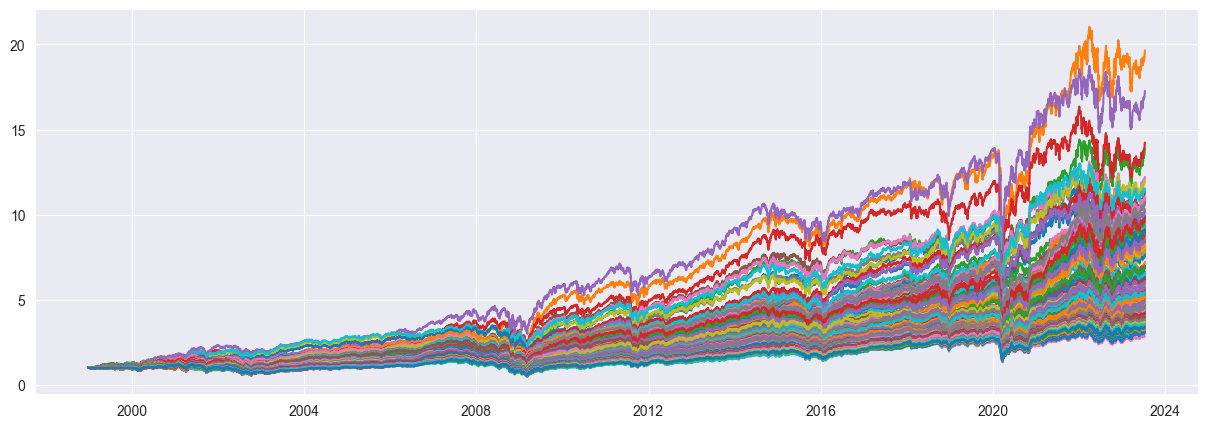

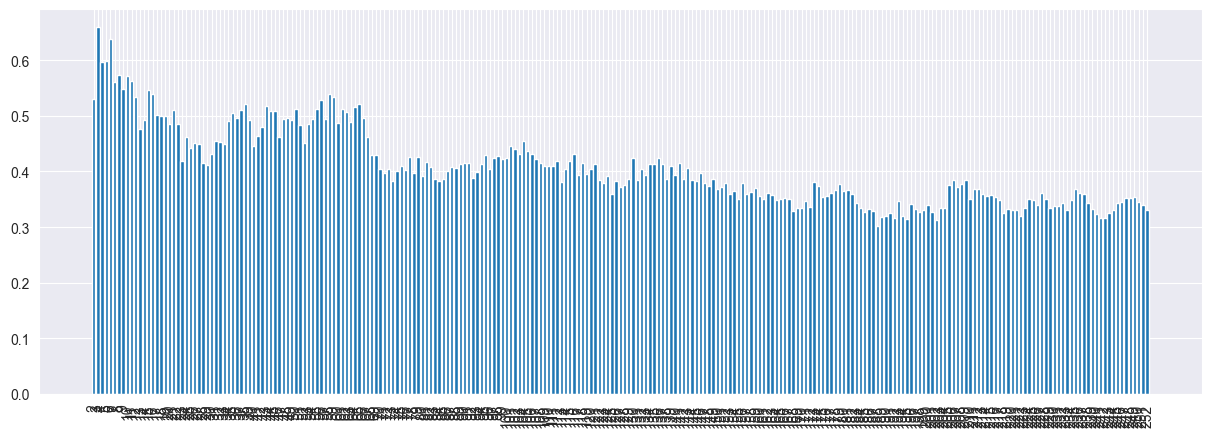

In [6]:
def backtest(dataframe, lookbacks, sharpes):
    for lookback in lookbacks:
        # weights = np.ones(len(dataframe.columns)) / len(dataframe.columns)

        signal = dataframe.rolling(lookback).sum()

        means = signal.mean(axis=1)
        stds = signal.std(axis=1)
        normalized_signal = (signal.values - means.values[:, np.newaxis]) / stds.values[:, np.newaxis]
        signal = pd.DataFrame(normalized_signal, index=signal.index, columns=signal.columns)

        signal = signal[signal < 0]
        weights = signal.rank(axis=1, method='first', ascending=False) #true if highest #false if lowest
        weights = weights.div(weights.sum(axis=1), axis=0) #faster than apply lambda
        signal = np.sign(signal)
        signal *= -1

        weighted_signal = signal.mul(weights)

        portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)

        cumulative_returns = (portfolio_returns + 1).cumprod()

        plt.plot(cumulative_returns)

        # print('Sharpe', (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))
        sharpes.append((portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))

    # plt.legend(lookbacks)
    plt.show()

    plt.bar(lookbacks, sharpes, tick_label=lookbacks)
    plt.xticks(rotation=90)

    # sns.heatmap(np.array(sharpes).reshape(len(lookbacks), len(lookbacks)), xticklabels=lookbacks, yticklabels=lookbacks)
    # plt.show()

backtest(normalizedDataframe, lookbacks, [])

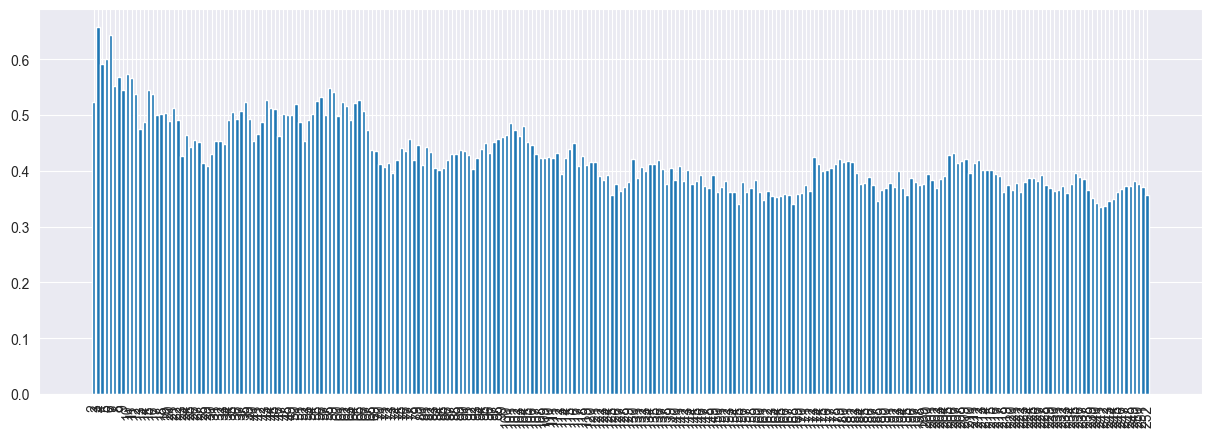

In [7]:
# divide dataframe into 2 and combine the average scores of both sharpes and mdds and plot that
def backtest(dataframe, lookbacks):
    first = dataframe.iloc[:int(len(dataframe)/3)]
    second = dataframe.iloc[int(len(dataframe)/3):int(len(dataframe)/3)*2]
    third = dataframe.iloc[int(len(dataframe)/3)*2:]

    dataframes = [first, second, third]

    sharpes = np.zeros((len(lookbacks), 3))

    for i, dataframe in enumerate(dataframes):
        # print('Fold', i+1)
        for j, lookback in enumerate(lookbacks):

            # weights = np.ones(len(dataframe.columns)) / len(dataframe.columns)

            signal = dataframe.rolling(lookback).sum()

            means = signal.mean(axis=1)
            stds = signal.std(axis=1)
            normalized_signal = (signal.values - means.values[:, np.newaxis]) / stds.values[:, np.newaxis]
            signal = pd.DataFrame(normalized_signal, index=signal.index, columns=signal.columns)

            signal = signal[signal < 0]
            weights = signal.rank(axis=1, method='first', ascending=False)
            weights = weights.div(weights.sum(axis=1), axis=0) #faster than apply lambda
            signal = np.sign(signal)
            signal *= -1

            weighted_signal = signal.mul(weights)

            portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)
            cumulative_returns = (portfolio_returns + 1).cumprod()
            # plt.plot(cumulative_returns)

            # print(lookback)
            # print('Sharpe', (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))
            sharpes[j, i] = (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252))

    sharpes = sharpes.mean(axis=1)

    plt.bar(lookbacks, sharpes, tick_label=lookbacks)
    plt.xticks(rotation=90)
    plt.show()

    return np.argmax(sharpes)

highest_sharpe = backtest(normalizedDataframe, lookbacks)

Best Lookback Window 3
Sharpe 0.659


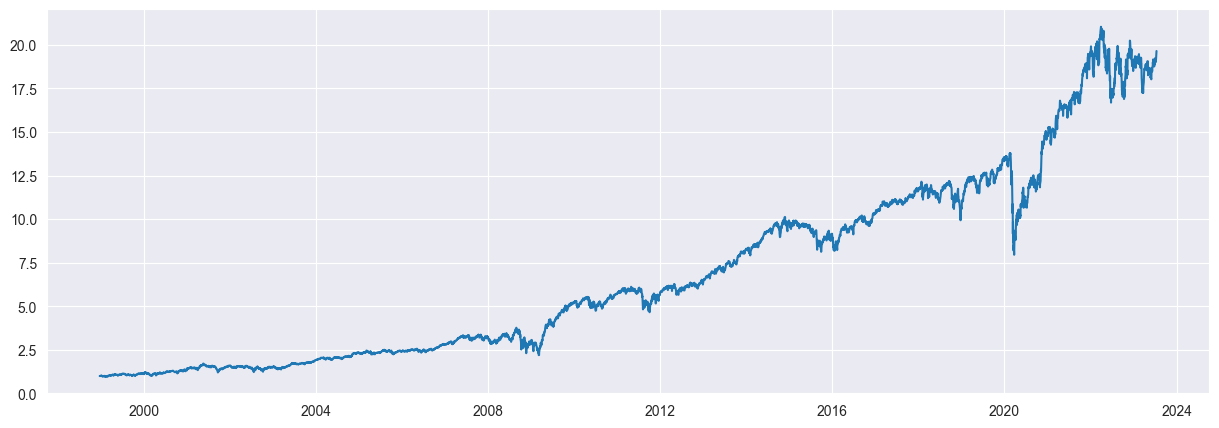

Assets contributing most to strategy (highest to lowest): 
XLF    0.665014
XLE    0.618355
XLK    0.532378
XLV    0.418239
XLU    0.373560
XLY    0.300898
XLI    0.244631
XLB    0.219873
XLP    0.206859
dtype: float64


In [8]:
def backtest(dataframe, highest_sharpe):
    lookback = lookbacks[highest_sharpe]

    print('Best Lookback Window', lookback)

    # weights = np.ones(len(dataframe.columns)) / len(dataframe.columns)

    signal = dataframe.rolling(lookback).sum()

    means = signal.mean(axis=1)
    stds = signal.std(axis=1)
    normalized_signal = (signal.values - means.values[:, np.newaxis]) / stds.values[:, np.newaxis]
    signal = pd.DataFrame(normalized_signal, index=signal.index, columns=signal.columns)

    signal = signal[signal < 0]
    weights = signal.rank(axis=1, method='first', ascending=False)
    weights = weights.div(weights.sum(axis=1), axis=0) #faster than apply lambda
    signal = np.sign(signal)
    signal *= -1

    weighted_signal = signal.mul(weights)

    portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)
    cumulative_returns = (portfolio_returns + 1).cumprod()
    plt.plot(cumulative_returns)

    # print sharpe to three decimal places
    print('Sharpe', round((portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)), 3))

    plt.show()

    column_returns = (weighted_signal.shift() * dataframe).sum()
    print('Assets contributing most to strategy (highest to lowest): ')
    print(column_returns.sort_values(ascending=False))

backtest(normalizedDataframe, highest_sharpe)

# Notes

The best lookback window for this long-only cross-sectional short-term reversal strategy is 3 days, and the highest returning sector is finance. The overall performance of this strategy is amazing.